In [1]:
import torch
from torchvision.models import resnet18

In [10]:
class model(torch.nn.Module):
    def forward(self, x): 
        x = x * 2 
        x.add_(0) 
        x = x.view(-1) 
        if x[0] > 1: 
            return x[0] 
        else: 
            return x[-1]

In [11]:
dummy_input = torch.randn(1,3,224, 224)

In [16]:
traced = torch.jit.trace(model(), dummy_input)
print(traced.graph)

graph(%self : __torch__.___torch_mangle_2.model,
      %x.1 : Float(1, 3, 224, 224, strides=[150528, 50176, 224, 1], requires_grad=0, device=cpu)):
  %4 : Long(requires_grad=0, device=cpu) = prim::Constant[value={2}]() # /tmp/ipykernel_18476/4122361919.py:3:0
  %x.3 : Float(1, 3, 224, 224, strides=[150528, 50176, 224, 1], requires_grad=0, device=cpu) = aten::mul(%x.1, %4) # /tmp/ipykernel_18476/4122361919.py:3:0
  %6 : Long(requires_grad=0, device=cpu) = prim::Constant[value={0}]() # /tmp/ipykernel_18476/4122361919.py:4:0
  %7 : int = prim::Constant[value=1]() # /tmp/ipykernel_18476/4122361919.py:4:0
  %x.5 : Float(1, 3, 224, 224, strides=[150528, 50176, 224, 1], requires_grad=0, device=cpu) = aten::add_(%x.3, %6, %7) # /tmp/ipykernel_18476/4122361919.py:4:0
  %9 : int = prim::Constant[value=-1]() # /tmp/ipykernel_18476/4122361919.py:5:0
  %10 : int[] = prim::ListConstruct(%9)
  %x : Float(150528, strides=[1], requires_grad=0, device=cpu) = aten::view(%x.5, %10) # /tmp/ipykernel_18476/

/tmp/ipykernel_18476/4122361919.py:6: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x[0] > 1:


In [17]:
traced.save("traced.pth")

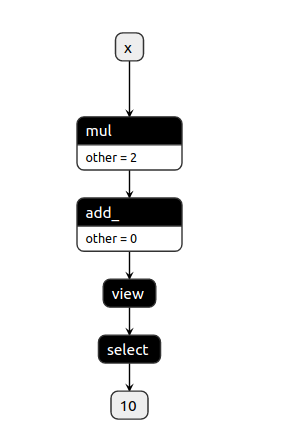

##### Graph

表格中Graph列整体用来表示一个Graph，它有如下性质

- Graph 用来表示一个“函数”，一个 Module 中的不同函数（比如 forward 等）会被转换成不同的 Graph。 
- Graph 拥有许多的 Node，这些 Node 由一个 Block 管理。所有 Node 组织成双向链表的形式，方便插入删除，其中返回值节点“Return Node”会作为这个双向链表的“哨兵”。双向链表通常会被拓扑排序，保证执行的正确性。 

##### Node

表格中 Graph 列里 3~14 行，以及 16和19 行表示各个Node，一个 Node 对应一个操作。操作的输入为 Value，少数情况下还会有一些 static attribute。Node 中包含很多信息，包括：

- kind() 表示 Node 的操作类型，上图中的aten::mul和prim::ListConstruct等都是对应 Node 的 kind。注意它只是个字符串，因此修改这个字符串也就意味着修改了操作。
- 常用的函数的 schema 可以在aten/src/ATen/native/native_functions.yaml中查看。
- FunctionSchema 指对这个函数的接口的描述，格式看起来就类似 ops 函数的声明，另外可以添加一些标记表示某个 Tensor 是否是另一个 Tensor 的 Alias 等等（别名分析是保证优化结果正确的依据），可以作为 peelhole-optimize 的时候的检索依据。以Tensor.add_函数为例

// add_是一个inplace运算，因此输出和self共享相同的内存空间 
// FunctionSchema中标注了这种别名关系，保证了输出的正确性 
// netron的可视化似乎不会进行alias analysis?因此上面右图的可视化中，add_的部分存在错误 
"add_.Scalar(Tensor(a!) self, Scalar other, Scalar alpha=1) -> Tensor(a!)" 

##### Block

Block表示一个 Node 的有序列表，代表输入的 Node 的kind=Param，代表输出的 Node 的kind=Return。

实际上 Graph 本身隐含一个 root Block 对象，用来管理所有的 Node。部分 Node 可能还会存在 sub Block。比如表中的 Graph 就有3个 Block，一个是 Graph 隐含的 root Block，另两个是prim::If Node 的 sub Block。

Block 的概念可能源于编译原理中的基本块。所谓基本块就是一系列不包含任何跳转指令的指令序列，由于基本块内的内容可以保证是顺序执行的，因此很多的优化都会以基本块作为前提。实际上 PyTorch 中对中间表示（IR）的优化有非常多是 Block 级别的。 

##### Value

Value是 Node 的输入输出，可以是 Tensor 也可以是容器或其他类型，可以通过type()判断。

Value 对象维护了一个 use_list，只要这个 Value 成为某个 Node 的输入，那么这个 Node 就要加入到它的 use_list 中。通过这个 use_list，可以很方便地解决新加入的 Node 与其他 Node 的输入输出关系。

注意：Value 是用来表述 Graph 的结构的，与 Runtime 无关！真正在推理时用到的是 IValue 对象，IValue 中有运行时的真实数据。 

##### Pass

严格地说这不是 Graph 的一部分，pass 是一个来源于编译原理的概念，它会接收一种中间表示（IR），遍历它并且进行一些变换，生成满足某种条件的新 IR。

TorchScript 中定义了许多 pass 来优化 Graph。比如对于常规编译器很常见的 DeadCodeElimination（DCE），CommonSubgraphElimination(CSE)等等；也有一些针对深度学习的融合优化，比如 FuseConvBN 等；还有针对特殊任务的 pass，ONNX 的导出就是其中一类 pass。 

## JIT Trace 

Jit trace 在 python 侧的接口为torch.jit.trace，输入的参数会经过层层传递，最终会进入torch/jit/frontend/trace.cpp中的trace函数中。这个函数是 Jit trace 的核心，大致执行了下面几个步骤：

- 创建新的TracingState对象，该对象会维护 trace 的 Graph 以及一些必要的环境参数。 
- 根据 trace 时的模型输入参数，生成 Graph 的输入节点。 
- 进行模型推理，同时生成 Graph 中的各个元素。 
- 生成 Graph 的输出节点。 进行一些简单的优化。 